## Our Environment [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/)

### Description
The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

### Action Space
The action is a ndarray with shape (1,) representing the torque applied to free end of the pendulum.

| Num | Action | Min  | Max  |
|-----|--------|------|------|
| 0   | Torque | -2.0 | 2.0  |


### Observation Space
The observation is a ndarray with shape (3,) representing the x-y coordinates of the pendulum’s free end and its angular velocity.

| Num | Observation          | Min  | Max  |
|-----|----------------------|------|------|
| 0   | x = cos(theta)       | -1.0 | 1.0  |
| 1   | y = sin(theta)       | -1.0 | 1.0  |
| 2   | Angular Velocity     | -8.0 | 8.0  |


### Rewards
The reward function is defined as:

r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)

where theta is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is -(pi2 + 0.1 * 82 + 0.001 * 22) = -16.2736044, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

### Starting State
The starting state is a random angle in [-pi, pi] and a random angular velocity in [-1,1].

### Episode Truncation
The episode truncates at 200 time steps.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

import time
from pprint import pprint
import numpy as np

import random

import pandas as pd
from collections import defaultdict

from tqdm.notebook import tqdm
from tqdm import trange

## Solutions

### Random Policy

C:\Users\mainj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Step: 0 [-0.99902225 -0.04420986 -0.16474894] -9.543501264025037 False {}
Step: 10 [-0.9908131   0.13523844 -0.33864656] -9.146219244090439 False {}
Step: 20 [-0.98384714 -0.17901051  0.87921375] -9.107451327284963 False {}
Step: 30 [-0.99999106 -0.00422816 -1.1439512 ] -9.564207294158862 False {}
Step: 40 [-0.9962258   0.08680002  0.75597477] -9.180239510383716 False {}
Step: 50 [-0.9732193  -0.2298787  -0.21590988] -8.403338314453759 False {}
Step: 60 [-0.978706    0.20526709 -1.0209467 ] -9.104341294285204 False {}
Step: 70 [-0.95684785  0.29058933  0.84241045] -7.929347799339497 False {}
Step: 80 [-0.9108761 -0.4126799  0.9984151] -7.794463699670147 False {}
Step: 90 [-0.9866156 -0.1630633 -1.4671617] -8.61153797933163 False {}
Step: 100 [-0.86663806  0.49893737 -0.3427777 ] -7.048664910794278 False {}
Step: 110 [-0.9971084  -0.07599238  1.772041  ] -10.048550982873149 False {}
Step: 120 [-0.85977876 -0.5106667  -0.61021394] -6.64423677848557 False {}
Step: 130 [-0.9061864   0.4228

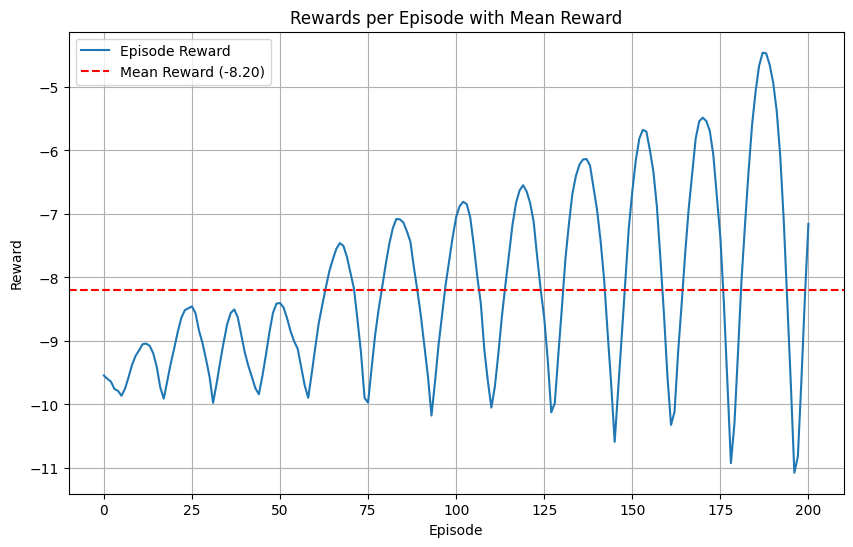

In [2]:
def random_policy(env, state):
    return env.action_space.sample()

env = gym.make('Pendulum-v1', render_mode='human')
state = env.reset()[0]

episode_rewards = []

for counter in range(201):
    env.render()

    action = random_policy(env, state)

    next_state, reward, done, truncated, info = env.step(action)

    episode_rewards.append(reward)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)

env.close()

mean_reward = sum(episode_rewards) / len(episode_rewards)

plt.figure(figsize=(10, 6))
plt.plot(range(201), episode_rewards, label='Episode Reward')

plt.axhline(y=mean_reward, color='r', linestyle='--', label=f'Mean Reward ({mean_reward:.2f})')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode with Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

In [4]:
# there are only two observables - position and velocity
print(env.observation_space.high)  # the high values of the observations
print(env.observation_space.low)  # the low values

[1. 1. 8.]
[-1. -1. -8.]


In [5]:
DISCRETE_BUCKETS = [20, 20, 20]

In [6]:
def discretised_state(DISCRETE_BUCKETS, state):

	minimum_values = env.observation_space.low
	maximum_values = env.observation_space.high + .001

	WINDOW_SIZE = np.divide(np.subtract(maximum_values, minimum_values), DISCRETE_BUCKETS)
	discrete_state = np.floor(np.divide(np.subtract(state, minimum_values), WINDOW_SIZE)).astype('int')

	return tuple(discrete_state)	# tuple as we need to use it later on to extract Q table values

In [7]:
print('LOWEST BINS:', discretised_state(DISCRETE_BUCKETS, env.observation_space.low))

print('HIGHEST BINS:',discretised_state(DISCRETE_BUCKETS, env.observation_space.high))

LOWEST BINS: (np.int64(0), np.int64(0), np.int64(0))
HIGHEST BINS: (np.int64(19), np.int64(19), np.int64(19))


In [8]:
def initialize_Q_table(env, DISCRETE_BUCKETS):

    DISCRETE_ACTIONS = 10

    # Initialize full on Null
    Q_table = np.zeros(shape=(DISCRETE_BUCKETS + [DISCRETE_ACTIONS]))

    # Initialize with random values, which ones?
    #Q_table = np.random.uniform(-1, 0, size=(DISCRETE_BUCKETS+[env.action_space.n]))

    return Q_table

In [9]:
Q_table = initialize_Q_table(env, DISCRETE_BUCKETS)

# State (0, 0) and all it's three respective q values

state = (0, 0)

Q_table[state]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
def epsilon_greedy_policy(env, state, Q_table, epsilon=.5, n_actions=3):

    #sample a random value from the uniform distribution, if the sampled value is less than
    #epsilon then we select a random action else we select the best action which has maximum Q
    #value as shown below

    if np.random.uniform(0,1) < epsilon:
        return np.random.randint(0, n_actions)
    else:
        return np.argmax(Q_table[state])

In [11]:
state = (0, 0)

epsilon_greedy_policy(env, state, Q_table, epsilon=.5)

np.int64(0)

### SARSA

**SARSA** (State-Action-Reward-State-Action) is an on-policy reinforcement learning algorithm that updates Q-values based on the action taken by the agent.

**Strengths:**
- **Simple**: Easy to implement and understand.
- **Stable**: Tends to be more stable when following the policy during training.

**Limitations:**
- **Exploration**: Depends heavily on the exploration strategy (e.g., epsilon-greedy).
- **Slow Convergence**: Can take longer to converge compared to off-policy methods.
- **Inefficient**: Struggles in environments with large state-action spaces.

**Why SARSA for Pendulum?**
- Simple and effective for smaller, discretized tasks.


In [12]:
def action_transform(env, action, n_actions):
    return [env.action_space.low[0] + action * ((env.action_space.high[0] - env.action_space.low[0]) / (n_actions-1))]

In [13]:
def SARSA_STEP(env, DISCRETE_BUCKETS, action, current_q_value, discrete_state, Q_table, alpha, gamma, epsilon, n_actions=3):

    continuous_action = action_transform(env, action, n_actions)

    # perform the selected action and store the next state information:
    next_continuous_state, r, truncated, done, _ = env.step(continuous_action)

    # Verify if episode is over
    Done = done | truncated

    if Done:
        return 0, 0, 0, r, Done

    # Calculate Next Discrete State
    next_discrete_state = discretised_state(DISCRETE_BUCKETS, next_continuous_state)

    # select the action a dash in the next state using the epsilon greedy policy:
    next_action = epsilon_greedy_policy(env, next_discrete_state, Q_table, epsilon=epsilon, n_actions=n_actions)

    # compute the Q value of the next state-action pair
    next_q_value = Q_table[next_discrete_state][next_action]

    # Calculate the new Q value
    new_q_value = current_q_value + alpha*(r + gamma*next_q_value - current_q_value)

    # update the new Q value
    Q_table[discrete_state][action] = new_q_value

    # update next state to current state
    discrete_state = next_discrete_state

    # update next action to current action
    action = next_action

    # update the next q_value to current q value
    current_q_value = next_q_value

    return action, current_q_value, discrete_state, r, Done

In [14]:
def TD_control(env, DISCRETE_BUCKETS, STEP_FUNCTION, num_iteractions=100, alpha=.1, gamma=.9, n_actions=3):

    start_time = time.time()

    # Store the respective return for each episode
    RETURN_LIST = []

    # We introduce EPSILON Decay, a way to progressively decrease exploration to explotion
    EPSILON = 1
    EPSILON_DECAY = EPSILON / num_iteractions

    # Initialize Q Table
    Q_table = initialize_Q_table(env, DISCRETE_BUCKETS)

    # for each episode
    for i in tqdm(range(num_iteractions)):

        # Initialize the state by resetting the environment and Discretize the state
        discrete_state = discretised_state(DISCRETE_BUCKETS, env.reset()[0])

        # select the action using the epsilon-greedy policy
        action = epsilon_greedy_policy(env, discrete_state, Q_table, EPSILON, n_actions=n_actions)

        # select the current q_value
        current_q_value = Q_table[discrete_state][action]

        # Start Calculating each episode's return
        CUMULATIVE_REWARD = 0

        # Tracking when the episode is over
        Done = False

        # Tracking number of steps per episode
        STEP = 0

        #for each step in the episode:
        while not Done:

            # Run SARSA
            action, current_q_value, discrete_state, r, Done = STEP_FUNCTION(env, DISCRETE_BUCKETS, action, current_q_value, discrete_state, Q_table, alpha, gamma, EPSILON, n_actions)

            # Store step-wise metrics
            CUMULATIVE_REWARD += r
            STEP += 1

            # if the current state is the terminal state then break:
            if Done:
                break

        # Store episode-wise metrics
        RETURN_LIST.append([i, STEP, CUMULATIVE_REWARD])

        # Update EPSILON to acccount for decay
        EPSILON -= EPSILON_DECAY

    # Metrics to benchmark learning process
    return_df = pd.DataFrame(RETURN_LIST, columns=['Episode', 'N_Steps', 'Return'])

    end_time = time.time()
    evaluation_time = end_time - start_time
    mean_reward_sarsa = np.mean(return_df['Return'])
    mean_length = np.mean(return_df['N_Steps'])

    print(f'Average Total Reward during Testing (SARSA): {mean_reward_sarsa:.2f}')
    print(f'Average Episode Length during Testing (SARSA): {mean_length:.2f}')
    print(f'Evaluation Time (SARSA): {evaluation_time:.2f} seconds')

    return Q_table, return_df, mean_reward_sarsa

In [15]:
env = gym.make('Pendulum-v1')

DISCRETE_BUCKETS = [20, 20, 20]
n_actions = 5

SARSA_Q_table, SARSA_return_df, mean_reward_sarsa = TD_control(env, DISCRETE_BUCKETS, SARSA_STEP, num_iteractions=5000, alpha=.1, gamma=.9, n_actions=n_actions)

env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

Average Total Reward during Testing (SARSA): -993.07
Average Episode Length during Testing (SARSA): 200.00
Evaluation Time (SARSA): 48.96 seconds


In [16]:
mean_reward_sarsa

np.float64(-993.0736104601286)

In [17]:
worst_sarsa = SARSA_return_df.loc[SARSA_return_df['Return'].idxmin()]
worst_sarsa

Episode     356.00000
N_Steps     200.00000
Return    -1812.98208
Name: 356, dtype: float64

In [18]:
worst_sarsa = worst_sarsa['Return']

In [19]:
best_sarsa = SARSA_return_df.loc[SARSA_return_df['Return'].idxmax()]
best_sarsa

Episode    4893.000000
N_Steps     200.000000
Return       -0.228101
Name: 4893, dtype: float64

In [20]:
best_sarsa = best_sarsa['Return']

As we can see, how lowest reward is a very bad value, however we can contrast that with our best value, which is very close to 0. This means that our agent is being able to learn correctly with the current policy and it achieves great results. <br>
About convergence we can't make any conclusion yet, however we may say (with a grain of salt) that the more episodes the agents learns on the closer it happears to get to 0.

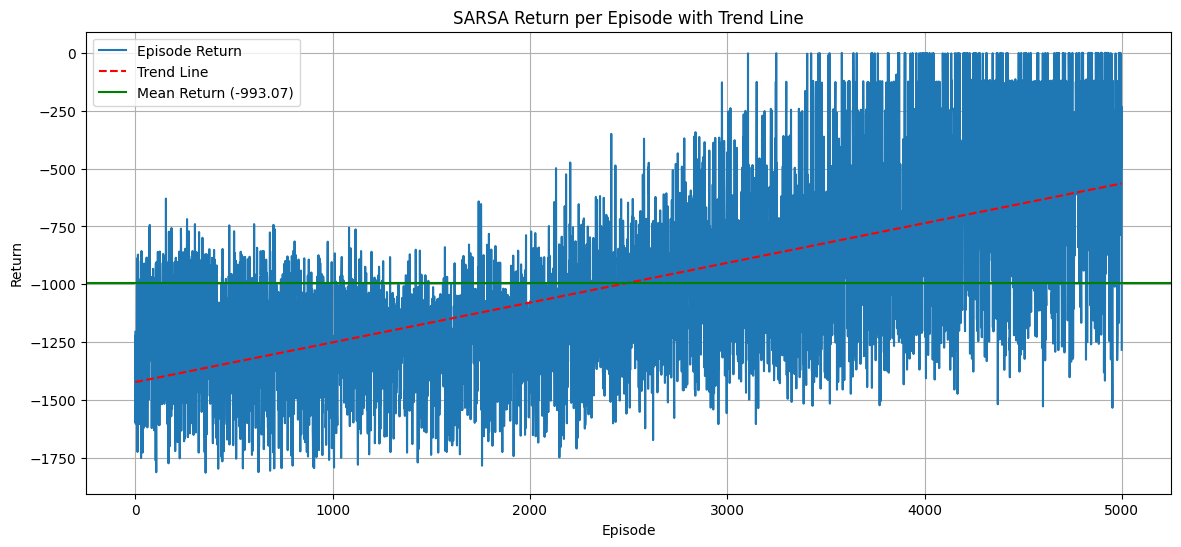

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(SARSA_return_df['Episode'], SARSA_return_df['Return'], label='Episode Return')

z = np.polyfit(SARSA_return_df['Episode'], SARSA_return_df['Return'], 1)
p = np.poly1d(z)
plt.plot(SARSA_return_df['Episode'], p(SARSA_return_df['Episode']), "r--", label='Trend Line')

mean_return = SARSA_return_df['Return'].mean()
plt.axhline(y=mean_return, color='g', linestyle='-', label=f'Mean Return ({mean_return:.2f})')

plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('SARSA Return per Episode with Trend Line')
plt.legend()
plt.grid(True)
plt.show()

Our trend line is very positive which means that the more episodes we have the closer the reward gets to 0, which in `Pendulum-v1` is a good thing. <br>
We still don't see a clear convergence, however the reward seems to be closer to 0 the more episodes we have.

### Q Learning

**Q-Learning** is a model-free, off-policy reinforcement learning algorithm that learns the value of state-action pairs (**Q(s, a)**). It uses the Bellman equation to iteratively update Q-values, which represent the expected cumulative reward for taking an action in a state.

**Strengths:**
- **Model-Free**: No need for a model of the environment.
- **Simple**: Easy to implement and works well in smaller tasks.

**Limitations:**
- **Scalability**: Struggles with large or continuous state-action spaces.
- **Exploration**: Needs efficient exploration strategies.

**Why Q-Learning for Pendulum?**
- The Pendulum environment can be discretized, making Q-Learning applicable.
- It's simple, making it a good fit for smaller tasks like Pendulum.


In [22]:
def Q_LEARNING_STEP(env, DISCRETE_BUCKETS, action, current_q_value, discrete_state, Q_table, alpha, gamma, epsilon, n_actions):

    continuous_action = action_transform(env, action, n_actions)

    # perform the selected action and store the next state information:
    next_continuous_state, r, truncated, done, _ = env.step(continuous_action)

    # Verify if episode is over
    Done = done | truncated

    if Done:
        return 0, 0, 0, r, Done

    # Calculate Next Discrete State
    next_discrete_state = discretised_state(DISCRETE_BUCKETS, next_continuous_state)

    # select the action a dash in the next state using the epsilon greedy policy:
    next_action = epsilon_greedy_policy(env, next_discrete_state, Q_table, epsilon=epsilon, n_actions=n_actions)

    # compute the Q value of the next state-action pair
    next_q_value = Q_table[next_discrete_state][next_action]

    #In SARSA we use the next_q_value
    max_future_q_value = np.max(Q_table[next_discrete_state])

    # Calculate the new Q value
    new_q_value = current_q_value + alpha*(r + gamma*max_future_q_value - current_q_value)

    # update the new Q value
    Q_table[discrete_state][action] = new_q_value

    # update next state to current state
    discrete_state = next_discrete_state

    # update next action to current action
    action = next_action

    # update the next q_value to current q value
    current_q_value = next_q_value

    return action, current_q_value, discrete_state, r, Done

In [23]:
def TD_control(env, DISCRETE_BUCKETS, STEP_FUNCTION, num_iteractions=100, alpha=0.1, gamma=0.9, n_actions=3):
    start_time = time.time()

    # Store the respective return for each episode
    RETURN_LIST = []

    # We introduce EPSILON Decay, a way to progressively decrease exploration to exploitation
    EPSILON = 1
    EPSILON_DECAY = EPSILON / num_iteractions

    # Initialize Q Table
    Q_table = initialize_Q_table(env, DISCRETE_BUCKETS)

    # For each episode
    for i in tqdm(range(num_iteractions)):

        # Initialize the state by resetting the environment and Discretize the state
        discrete_state = discretised_state(DISCRETE_BUCKETS, env.reset()[0])

        # select the action using the epsilon-greedy policy
        action = epsilon_greedy_policy(env, discrete_state, Q_table, EPSILON, n_actions=n_actions)

        # select the current q_value
        current_q_value = Q_table[discrete_state][action]

        # Start Calculating each episode's return
        CUMULATIVE_REWARD = 0

        # Tracking when the episode is over
        Done = False

        # Tracking number of steps per episode
        STEP = 0

        # For each step in the episode:
        while not Done:

            # Run Q-Learning Step
            action, current_q_value, discrete_state, r, Done = STEP_FUNCTION(env, DISCRETE_BUCKETS, action, current_q_value, discrete_state, Q_table, alpha, gamma, EPSILON, n_actions)

            # Store step-wise metrics
            CUMULATIVE_REWARD += r
            STEP += 1

            # if the current state is the terminal state then break:
            if Done:
                break

        # Store episode-wise metrics
        RETURN_LIST.append([i, STEP, CUMULATIVE_REWARD])

        # Update EPSILON to account for decay
        EPSILON -= EPSILON_DECAY

    # Metrics to benchmark learning process
    return_df = pd.DataFrame(RETURN_LIST, columns=['Episode', 'N_Steps', 'Return'])

    end_time = time.time()
    evaluation_time = end_time - start_time
    mean_reward = np.mean(return_df['Return'])
    mean_length = np.mean(return_df['N_Steps'])

    print(f'Average Total Reward during Testing (Q-Learning): {mean_reward:.2f}')
    print(f'Average Episode Length during Testing (Q-Learning): {mean_length:.2f}')
    print(f'Evaluation Time (Q-Learning): {evaluation_time:.2f} seconds')

    return Q_table, return_df, mean_reward

In [24]:
env = gym.make('Pendulum-v1')

DISCRETE_BUCKETS = [20, 20, 20]
n_actions = 5

Q_LEARNING_Q_table, Q_LEARNING_return_df, mean_reward_q = TD_control(env, DISCRETE_BUCKETS, Q_LEARNING_STEP, num_iteractions=5000, alpha=.1, gamma=.9, n_actions=n_actions)

env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

Average Total Reward during Testing (Q-Learning): -1061.82
Average Episode Length during Testing (Q-Learning): 200.00
Evaluation Time (Q-Learning): 62.88 seconds


In [25]:
worst_q = Q_LEARNING_return_df.loc[Q_LEARNING_return_df['Return'].idxmin()]
worst_q

Episode     191.000000
N_Steps     200.000000
Return    -1820.782969
Name: 191, dtype: float64

In [26]:
worst_q = worst_q['Return']

In [27]:
best_q = Q_LEARNING_return_df.loc[Q_LEARNING_return_df['Return'].idxmax()]
best_q

Episode    4890.000000
N_Steps     200.000000
Return       -0.503291
Name: 4890, dtype: float64

In [28]:
best_q = best_q['Return']

As we can see, how lowest reward is a very bad value, however we can contrast that with our best value, which is very close to 0. This means that our agent is being able to learn correctly with the current policy and it achieves great results. <br>

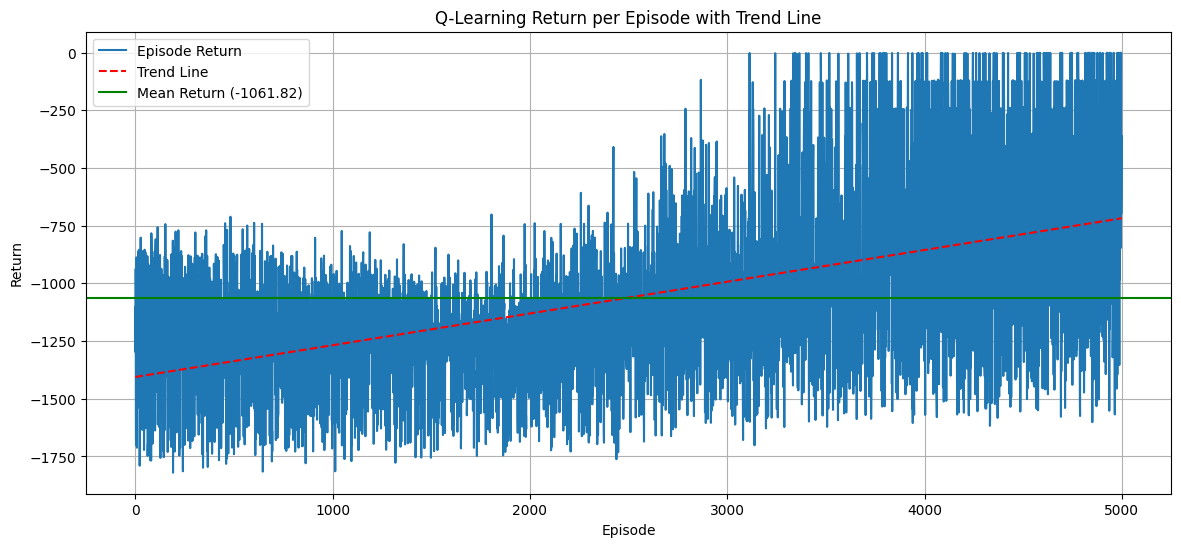

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(Q_LEARNING_return_df['Episode'], Q_LEARNING_return_df['Return'], label='Episode Return')

z = np.polyfit(Q_LEARNING_return_df['Episode'], Q_LEARNING_return_df['Return'], 1)
p = np.poly1d(z)
plt.plot(Q_LEARNING_return_df['Episode'], p(Q_LEARNING_return_df['Episode']), "r--", label='Trend Line')

mean_return = Q_LEARNING_return_df['Return'].mean()
plt.axhline(y=mean_return, color='g', linestyle='-', label=f'Mean Return ({mean_return:.2f})')

plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Q-Learning Return per Episode with Trend Line')
plt.legend()
plt.grid(True)
plt.show()

Our trend line is very positive which means that the more episodes we have the closer the reward gets to 0, which in `Pendulum-v1` is a good thing. <br>
We don't see convergence, and in this case the range between the lowest rewards and the highest rewards seems to grow bigger the more episodes we have.

## Conclusions

In [30]:
data = {
    "SARSA": [worst_sarsa, mean_reward_sarsa, best_sarsa],
    "Q-Learning": [worst_q, mean_reward_q, best_q]
}

# Create the table
df = pd.DataFrame(data, index=["Worst", "Mean", "Best"])

# Transpose the table
df_transposed = df.transpose()

# Define a function to apply styles
def style_table(val, col_min, col_max):
    if val == col_max:
        return 'background-color: green'
    elif val == col_min:
        return 'background-color: red'
    else:
        return ''

# Apply the styling
styled_df = df_transposed.style.apply(
    lambda x: [style_table(val, x.min(), x.max()) for val in x], axis=0
)

# Display the styled dataframe
styled_df

- SARSA and Q Learning achieved a reward close to 0 almost at the same time (close to the 3000th episode)
- SARSA was 13% faster to run the 5000 episodes when compared to Q Learning, however, these results are not very meaningful since we didn't achieve convergence
- Both showed that they were learning decently with the policy based on the increasing tendency line
- Fluctuations seen in both SARSA and Q Learning's rewards may tell us that the agent is still investing a lot in exploration or that the policy is yet not optimized